In [109]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy

## LRP Method

$\begin{aligned} r_i^{(L)} &= \begin{cases}S_i(x) & \text{if unit }i \text{ is the target unit of interest}\\ 0 & \text{otherwise}\end{cases}  \\ r_i^{(l)} &= \sum_j \dfrac{z_{ji}}{\sum_{i’}(z_{ji’}+b_j)+ \epsilon \cdot sign(\sum_{i’}(z_{ji’}+b_j))}r_j^{(l+1)}\\ &\text{where } z_{ji} = w_{ji}^{(l+1, l)}x_{i}^{(l)}\end{aligned} $

input feature $(1, \cdots, i, \cdots N)$, output feature $(1, \cdots, j, \cdots M)$

weight $(N, M)$ is transposed to $(M, N)$ in pytorch

$\begin{aligned} X^{(l+1)} &= \begin{bmatrix}  x_1 & \cdots  &x_M \end{bmatrix}^T\\
X^{(l)} &= \begin{bmatrix}  x_1 & \cdots  & x_N \end{bmatrix}^T\\
W^{(l+1, l)} &= \begin{bmatrix} 
w_{11} & \cdots & w_{1i} & \cdots & w_{1N} \\ 
\vdots & \ddots & \ddots & \ddots & \vdots \\ 
w_{j1} & \ddots & w_{ji} & \ddots & w_{jN} \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
w_{M1} & \cdots & w_{Mi} & \cdots & w_{MN}
\end{bmatrix}
\end{aligned}$

to see element-wise calculation ...

$\begin{aligned} 
R^{(l)} &= \begin{bmatrix} r_1 \\ \vdots \\ r_i \\ \vdots \\ r_N\end{bmatrix}^{(l)} = \begin{bmatrix} \sum_j^M a_{1j}r_{1j} \\ \vdots \\ \sum_j^M a_{ij}r_{ij} \\ \vdots \\ \sum_j^M a_{Nj}r_{Nj} \end{bmatrix}^{(l)} = \begin{bmatrix} a_{11}r_{11} + \cdots + a_{1M}r_{1M} \\ \vdots \\ a_{i1}r_{i1} + \cdots + a_{iM}r_{iM} \\ \vdots \\ a_{N1}r_{N1} + \cdots + a_{NM}r_{NM} \end{bmatrix}^{(l)} 
\\
Z^{(l, l+1)} &= \begin{bmatrix} 
z_{11} & \cdots & z_{1j} & \cdots & z_{1M} \\ 
\vdots & \ddots & \ddots & \ddots & \vdots \\ 
z_{i1} & \ddots & z_{ij} & \ddots & z_{ij} \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
z_{N1} & \cdots & z_{Nj} & \cdots & z_{NM}
\end{bmatrix} = \begin{bmatrix} 
w_{11}x_1^{(l+1)} & \cdots & w_{1j}x_j^{(l+1)} & \cdots & w_{1M}x_M^{(l+1)} \\ 
\vdots & \ddots & \ddots & \ddots & \vdots \\ 
w_{i1}x_1^{(l+1)} & \ddots & w_{ij}x_j^{(l+1)} & \ddots & w_{ij}x_M^{(l+1)} \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
w_{N1}x_1^{(l+1)} & \cdots & w_{Nj}x_j^{(l+1)} & \cdots & w_{NM}x_M^{(l+1)}
\end{bmatrix}
\end{aligned}$

### 1st way

to get $r_i^{(l+1)}$ where $z_{ji}^{(l+1)} = w_{ji}^{(l+1, 1)} x_i^{(l)}$ there are 4 step in Linear Layer

$\begin{aligned} 
(1) & Z^{(l, l+1)} = W^{(l, l+1)} \times X^{(l+1)}\\
(2) & S^{(l+1)} = X^{(l+1)} + \epsilon \cdot sign(X^{(l+1)}) \\
(3) & A^{(l, l+1)} = \dfrac{Z^{(l, l+1)}}{S^{(l+1)}} \\
(4) & R^{(l)} = A^{(l, l+1)}R^{(l+1)}  \\
\end{aligned}$

### 2nd way

same calculation but different order, introducing at http://heatmapping.org/tutorial/

$\begin{aligned} 
(1) & S^{(l+1)} = X^{(l+1)} + \epsilon \cdot sign(X^{(l+1)}) \\
(2) & E^{(l+1)} = \dfrac{R^{(l+1)}}{S^{(l+1)}} \\
(3) & C^{(l)} = W^{(l, l+1)} E^{(l+1)} \\
(4) & R^{(l)} = X^{(l)} \times C^{(l)}  \\
\end{aligned}$

In [2]:
class relLinear(nn.Linear):
    def __init__(self, linear):
        super(nn.Linear, self).__init__()
        self.in_features = linear.in_features
        self.out_features = linear.out_features
        self.weight = linear.weight  # (out_f, in_f)
        self.bias = linear.bias  # out_f
        self.input = None
        self.output = None
        self.register()
        
    def register(self):
        self.register_forward_hook(self.hook_function)
    
    def hook_function(self, *x):
        _, i, o = x
        self.input = i[0].data
        self.output = o.data
        
    def rho(self, w, use_rho):
        if use_rho:
            return torch.clamp(w, min=0)
        else:
            return w
        
    def relprop(self, r, use_rho=False):
        """
        lrp method
            > * must run after `self.forward`
            > 
            > forward shape
            > input: (B, *, in_f)
            > output: (B, *, out_f)

        - relprop shape
        r = (l+1)-th layer: (B, *, out_f)
        r_next = l-th layer: (B, *, in_f)
        
        if rho==True:
        function rho(w) is applied
        """
        eps = 1e-6
        w = self.rho(self.weight, use_rho)
        ### implementation method 1
        ## (B, in_f, 1) * (1, in_f, out_f) = (B, in_f, out_f)
        #z = self.input.unsqueeze(-1) * self.rho(self.weight).transpose(0, 1).unsqueeze(0)
        ## (B, 1, out_f)
        #s = self.output.unsqueeze(1) + eps * torch.sign(self.output.unsqueeze(1))  
        #weight = z / s
        ## (B, in_f, out_f) x (B, out_f, 1) = (B, in_f)
        #r_next = torch.bmm(weight, r.unsqueeze(-1)).squeeze()
        
        ### implemetation method 2
        # Step 1: (B, out_f) 
        s = self.output + eps * torch.sign(self.output)  
        # Step 2: (B, out_f) / (B, out_f) = (B, out_f)
        e = r / s
        # Step 3: (B, in_f, out_f) * (B, out_f, 1) = (B, in_f)
        c = torch.bmm(w.transpose(0, 1).expand(e.size(0), self.in_features, self.out_features), 
                      e.unsqueeze(-1)).squeeze(-1)
        # Step 4: (B, in_f) x (B, in_f) = (B, in_f)
        r_next = self.input * c
        
        assert r_next.size(1) == self.in_features, "size of `r_next` is not correct"
        return r_next

In [3]:
a = nn.Linear(3, 2)
b = relLinear(a)
o = b(torch.rand(5, 3))

In [4]:
target_vector = torch.zeros(5, 2).scatter(1, torch.LongTensor([[1], [0], [0], [1], [0]]), 1)
target_vector  # l+1

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [5]:
b.relprop(target_vector)

tensor([[ 8.2037e+00, -2.5058e+01,  5.0031e+00],
        [-1.0748e-01, -6.5016e-01, -1.5516e+00],
        [-4.7735e-03, -1.1511e-01, -6.3940e-01],
        [ 1.3798e-01, -1.8393e-01,  9.8508e-02],
        [-5.0873e-02, -2.8419e-01, -1.1969e+00]], grad_fn=<MulBackward0>)

In convolutional layer to get $r_i^{(l+1)}$ there are 4 step in Conv Layer, but change step 3 computing gradient of conv. which can be replaced as Transposed convolutional layer(=fractionally strided convolutional layer)

$\begin{aligned} 
(1) & S^{(l+1)} = X^{(l+1)} + \epsilon \cdot sign(X^{(l+1)}) \\
(2) & E^{(l+1)} = \dfrac{R^{(l+1)}}{S^{(l+1)}} \\
(3) & C^{(l)} = \triangledown (\sum S^{(l+1)} \times E^{(l+1)}) \\
(4) & R^{(l)} = X^{(l)} \times C^{(l)}  \\
\end{aligned}$

In [70]:
class relReLU(nn.ReLU):
    
    def relprop(self, r): 
        return r

In [30]:
class relConv2d(nn.Conv2d):
    def __init__(self, conv2d):
        super(nn.Conv2d, self).__init__(conv2d.in_channels, 
                                        conv2d.out_channels, 
                                        conv2d.kernel_size, 
                                        conv2d.stride, 
                                        conv2d.padding,
                                        conv2d.dilation,
                                        conv2d.transposed,
                                        conv2d.output_padding,
                                        conv2d.groups, 
                                        None,  # init of bias
                                        conv2d.padding_mode)
        self.weight = conv2d.weight
        self.bias = conv2d.bias
        
        self.input = None
        self.output = None
        self.register()
        
    def register(self):
        self.register_forward_hook(self.hook_function)
    
    def hook_function(self, *x):
        _, i, o = x
        self.input = i[0].data
        self.output = o.data
    
    def rho(self, w, use_rho):
        if use_rho:
            return torch.clamp(w, min=0)
        else:
            return w
    
    def cal_output_padding(self):
        """
        calculate output_padding size
        - size of height or width: (X_in + 2P - K) / S + 1 = X_out
        - output_padding = X_in - ((X_out - 1) * S + K - 2P)

        * what is output_padding?
        from PyTorch Document:
        https://pytorch.org/docs/stable/nn.html#convtranspose2d

        The padding argument effectively adds `dilation * (kernel_size - 1) - padding` amount of zero padding to 
        both sizes of the input. This is set so that when a `Conv2d` and a `ConvTranspose2d` are initialized with 
        same parameters, they are inverses of each other in regard to the input and output shapes. 
        However, when `stride > 1`, `Conv2d` maps multiple input shapes to the same output shape. 
        `output_padding` is provided to resolve this ambiguity by effectively increasing 
        the calculated output shape on one side. Note that output_padding is only used to find output shape, 
        but does not actually add zero-padding to output.
        """
        H_in, W_in = self.input.size()[2:]
        H_out, W_out = self.output.size()[2:]
        S_in, S_out = self.stride
        K_in, K_out = self.kernel_size
        P_in, P_out = self.padding
        H_output_padding = H_in - ((H_out - 1)*S_in + K_in - 2*P_in)
        W_output_padding = W_in - ((W_out - 1)*S_out + K_out - 2*P_out)
        return (H_output_padding, W_output_padding)
    
    def gradprop(self, x):
        """
        `ConvTransposed2d` can be seen as the gradient of `Conv2d` with respect to its input.
        """
        output_padding = self.cal_output_padding()
        c = torch.nn.functional.conv_transpose2d(x, weight=self.weight, stride=self.stride, 
                                                 padding=self.padding, output_padding=output_padding)
        return c
    
    def relprop(self, r, use_rho=False):
        """
        lrp method
            > * must run after `self.forward`
            > 
            > forward shape
            > input: (B, C_in, H, W)
            > output: (B, C_out, H_out, W_out)

        - relprop shape
        r = (l+1)-th layer: (B, C_out, H_out, W_out)
        r_next = l-th layer: (B, C_in, H, W)
        
        if rho==True:
        function rho(w) is applied
        """
        eps = 1e-6
        w = self.rho(self.weight, use_rho)
        # Step 1: (B, C_out, H_out, W_out) 
        s = self.output + eps * torch.sign(self.output)  
        # Step 2: (B, C_out, H_out, W_out) / (B, C_out, H_out, W_out) = (B, C_out, H_out, W_out)
        e = r / s
        # Step 3: (B, C_out, H_out, W_out) --> (B, C_in, H, W)
        # same as `self.gradprop(s*e)` or `(s*e).backward(); c=self.input.grad`
        c = self.gradprop(e)
        # Step 4: (B, C_in, H, W) x (B, C_in, H, W) = (B, C_in, H, W)
        r_next = self.input * c
        return r_next

In [31]:
a = nn.Conv2d(1, 32, 3)
b = relConv2d(a)

In [32]:
output = b(torch.randn(2, 1, 28, 28))
r = torch.relu(output)

In [34]:
r_next = b.relprop(r)
r_next.size()

torch.Size([2, 1, 28, 28])

Maxpooling layer

In [92]:
class relMaxPool2d(nn.MaxPool2d):
    def __init__(self, maxpool2d):
        super(nn.MaxPool2d, self).__init__(maxpool2d.kernel_size,
                                           maxpool2d.stride,
                                           maxpool2d.padding,
                                           maxpool2d.dilation,
                                           maxpool2d.return_indices,
                                           maxpool2d.ceil_mode)    
        self.input = None
        self.output = None
        self.register()

    def register(self):
        self.register_forward_hook(self.hook_function)
    
    def hook_function(self, *x):
        _, i, o = x
        self.input = i[0].data
        self.output = o.data
        
    def gradprop(self, x):
        _, switches = torch.nn.functional.max_pool2d(self.input, self.kernel_size, self.stride, self.padding, 
                                                     self.dilation, self.ceil_mode, return_indices=True)
        c = torch.nn.functional.max_unpool2d(x, switches, self.kernel_size, self.stride, self.padding)
        return c
    
    def relprop(self, r):
        """
        lrp method
            > * must run after `self.forward`
            > 
            > forward shape
            > input: (B, C, H, W)
            > output: (B, C, H_out, W_out)

        - relprop shape
        r = (l+1)-th layer: (B, C, H_out, W_out)
        r_next = l-th layer: (B, C, H, W)
        """
        eps = 1e-6
        # Step 1: (B, C, H_out, W_out) 
        s = self.output + eps * torch.sign(self.output)  
        # Step 2: (B, C, H_out, W_out) / (B, C, H_out, W_out) = (B, C, H_out, W_out)
        e = r / s
        # Step 3: (B, C, H_out, W_out) --> (B, C, H, W)
        # same as `self.gradprop(s*e)` or `(s*e).backward(); c=self.input.grad`
        c = self.gradprop(e)
        # Step 4: (B, C, H, W) x (B, C, H, W) = (B, C_in, H, W)
        r_next = self.input * c
        return r_next

In [104]:
a = nn.MaxPool2d(2)
b = relMaxPool2d(a)
x = torch.randn(2, 32, 26, 26)
output = b(x)

In [105]:
r_next = b.relprop(output)
r_next.size()

torch.Size([2, 32, 26, 26])

In [117]:
class Reshape(nn.Module):
    def __init__(self):
        """
        reshape layer
        - forward: flatten at convs > linear
        - backward: unflatten at linear > convs     
        """
        super(Reshape, self).__init__()
    
    def __name__(self):
        return "Reshape"
    
    def forward(self, x):
        """
        reshape input to output
        input: (B, C, H, W)
        output: (B, C*H*W)
        """
        self.B, self.C, self.H, self.W = x.size()
        return x.view(self.B, -1)
    
    def relprop(self, x):
        """
        lrp method
            > * must run after `self.forward`
            > 
            > forward shape
            > input: (B, C, H, W)
            > output: (B, C*H*W)

        - relprop shape
        r = (l+1)-th layer: (B, C*H*W)
        r_next = l-th layer: (B, C, H, W)
        """
        return x.view(-1, self.C, self.H, self.W)

In [120]:
rs = Reshape()
x = torch.rand(2, 1, 12, 12)
output = rs(x)

In [ ]:
class lrpMNIST(nn.Module):
    def __init__(self, model):
        super(lrpMNIST, self).__init__()
        
        # lrp
        self.activation_func = model.activation_func
        self.model_type = model.model_type
        self.activation_type = model.activation_type
        self.convs_len = model.convs_len
        self.fc_len = model.fc_len
        self.convs = model.convs
        self.fc = model.fc
            

In [112]:
model_type = "cnn"
activation_type = "relu"
m = deepcopy(MNISTmodel(model_type, activation_type))

In [113]:
m.convs

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

---

In [131]:
class MNISTmodel(nn.Module):
    """
    paper implementation 'https://arxiv.org/abs/1711.06104'
    
    model_type: 
        - DNN: 
            Reshape: 28,28 > 28*28
            Linear: 28*28, 512 
            Linear: 512, 512
            Linear: 512, 10
        - CNN: 
            Conv2d: (1, 32, 3)
            Conv2d: (32, 64, 3)
            MaxPool2d: (2)
            Reshape: 12,12 > 12*12
            Linear: (64*12*12, 128)
            Linear: (128, 10)

            ** Conv2d = (in_kernels, out_kernels, kernel_size)
            ** MAxPool2d = (kernel_size)

    activation_type:
        - ReLU, Tanh, Sigmoid, Softplus
    """
    def __init__(self, model_type, activation_type):
        """
        model_type: "dnn", "cnn"
        activation_type: "relu", "tanh", "sigmoid", "softplus"
        """
        super(MNISTmodel, self).__init__()
        self.model_type = model_type
        self.activation_type = activation_type
        self.act = {"relu": nn.ReLU, 
                    "tanh": nn.Tanh, 
                    "sigmoid": nn.Sigmoid, 
                    "softplus": nn.Softplus}
        
        self.layers = self.make_layers(model_type, activation_type)
        
        if model_type == "cnn":
            self.switches = OrderedDict()
            self.maxpool2d_locs = []
            
        self.activation_maps = OrderedDict()
        self.activation_locs = []
        
    def make_layers(self, model_type, activation_type):
        self.activation_func = self.act[activation_type.lower()]
        if model_type.lower() == "dnn":
            layers = nn.Sequential(
                Reshape(),
                nn.Linear(28*28, 512),
                self.activation_func(), 
                nn.Linear(512, 512),
                self.activation_func(), 
                nn.Linear(512, 10),
            )
        elif model_type.lower() == "cnn":
            layers = nn.Sequential(
                nn.Conv2d(1, 32, 3),
                self.activation_func(),
                nn.Conv2d(32, 64, 3),
                self.activation_func(), 
                nn.MaxPool2d(2, return_indices=True),
                Reshape(),
                nn.Linear(64*12*12, 128),
                self.activation_func(),
                nn.Linear(128, 10)
            )
        else:
            assert False, "please insert `model_type` = `dnn` or `cnn`"
        return layers
    
    def save_activation_maps(self, layer, idx, x, typ):
        if isinstance(layer, self.activation_func):
            layer_name = f"{typ}{idx}"
            self.activation_locs.append(layer_name)  # only for record
            self.activation_maps[layer_name] = x
    
    def forward(self, x, store=False):
        """
        store: if True, save activation maps
        """
        for idx, layer in enumerate(self.layers):
            if isinstance(layer, nn.MaxPool2d):
                x, indices = layer(x)
                self.switches[idx] = indices  # for deconvnet
                self.maxpool2d_locs.append(idx)  # only for record
            else:
                x = layer(x)
                if store:
                    self.save_activation_maps(layer, idx, x, typ=layer.__name__)
        return x

In [67]:
class deconvMNIST(nn.Module):
    def __init__(self, model):
        super(deconvMNIST, self).__init__()
                
        # deconv
        self.activation_func = model.activation_func
        self.model_type = model.model_type
        self.activation_type = model.activation_type

        if self.model_type == "cnn":
            self.switches = model.switches
        self.convs, self.fc = self.deconv_make_layers()
        
    def deconv_make_layers(self):
        if self.model_type.lower() == "dnn":
            convs = None
            fc = nn.Sequential(
                nn.Linear(10, 512),
                self.activation_func(), 
                nn.Linear(512, 512),
                self.activation_func(), 
                nn.Linear(512, 28*28),
            )
        elif self.model_type.lower() == "cnn":
            fc = nn.Sequential(
                nn.Linear(10, 128),
                self.activation_func(),
                nn.Linear(128, 64*12*12)    
            )
            convs = nn.Sequential(
                nn.MaxUnpool2d(2),
                self.activation_func(), 
                nn.ConvTranspose2d(64, 32, 3),
                self.activation_func(),
                nn.ConvTranspose2d(32, 1, 3),
            )
        else:
            assert False, "[init error] `model` doesn't have `model_type` or `activation_func` attrs"
        return convs, fc
    
    def forward(self, t):
        x = self.fc(t)
        if self.convs is not None:
            x = x.view(x.size(0), 64, 12, 12)
            for idx, layer in enumerate(self.convs):
                if isinstance(layer, nn.MaxUnpool2d):
                    x = layer(x, self.switches[self.convs_len - 1 - idx])
                else:
                    x = layer(x)
        return x

In [68]:
class saliencyMNIST(nn.Module):
    def __init__(self, model):
        super(saliencyMNIST, self).__init__()
        """
        model_type: "dnn", "cnn"
        activation_type: "relu", "tanh", "sigmoid", "softplus"
        """
        super(saliencyMNIST, self).__init__()

        self.activation_func = model.activation_func
        self.model_type = model.model_type
        self.activation_type = model.activation_type
        self.convs_len = model.convs_len
        self.fc_len = model.fc_len
        # TODO: rewrite code
        self.model = deepcopy(model)
        self.model.eval()
        
    def generate_saliency(self, x, target):
        """vanilla gradient*input"""
        x.requires_grad_(requires_grad=True)
        self.model.zero_grad()
        output = self.model(x)
        grad_outputs = torch.zeros_like(output)
        grad_outputs[:, target] = 1

        output.backward(gradient=grad_outputs)
        x.requires_grad_(requires_grad=False)
        
        return x.grad.clone() * x

In [36]:
def build_dataset(root, batch_size, download=False):
    train_dataset = datasets.MNIST(
        root=root,                                
        train=True,
        transform=transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.5,), (0.5,))  # normalize to (-1, 1)
        ]),
        download=download)
    test_dataset = datasets.MNIST(
        root=root, 
        train=False,
        transform=transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.5,), (0.5,))
        ]),
        download=download)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, 
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size, 
        shuffle=True)
    return train_dataset, test_dataset, train_loader, test_loader

In [ ]:
activation_types = ["relu", "tanh", "sigmoid", "softplus"]
model_types = ["dnn", "cnn"]
args = dict(
    root = Path().home()/"code"/"data",
    project_path = Path().home()/"code"/"XAI",
    logterm = False, 
    sv_folder = "mnist", 
    n_step = 20,
    batch_size = 128,
    download = False,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    seed = 73
)
train_dataset, test_dataset, train_loader, test_loader = build_dataset(str(args["root"]), 1)

In [71]:
from collections import defaultdict
torch.manual_seed(74)

test_dataset.
for i in range(10):
    for imgs, labels in test_loader:
        
        break
    
num = 1
sample = imgs[:num]
sample_label = labels[:num]

In [93]:
model_type = "cnn"
activation_type = "relu"
model = MNISTmodel(model_type, activation_type)
model.load_state_dict(torch.load(f"./trained/mnist/{model_type}-{activation_type}.pt", map_location="cpu"))

output = model(sample, store=True)
pred = output.argmax(1)
target_vector = torch.zeros_like(output).scatter(1, sample_label.unsqueeze(0), 1).detach()

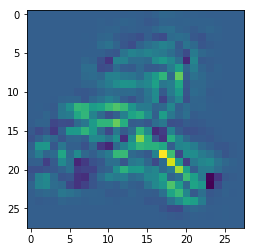

In [86]:
saliency = saliencyMNIST(model)
vanilla_saliency = saliency.generate_saliency(sample, pred)
plt.imshow(vanilla_saliency.squeeze()*0.5+0.5)
plt.show()

In [ ]:
# deconv = deconvMNIST(model)


In [50]:
model.switches[4].size()

torch.Size([1, 64, 12, 12])

In [6]:
def create_model(model_type, activation_type, load=True):
    model = MNISTmodel(model_type, activation_type)
    ex_model = explainMNISTmodel(model_type, activation_type)
    if load:
        model.load_state_dict(torch.load(f"./trained/mnist/{model_type}-{activation_type}.pt", map_location="cpu"))
    return model, ex_model

def run_backward(x, oc_x, target, model):
    loss_function = nn.CrossEntropyLoss()
    ret = []
    for img in [x, oc_x]:
        img = img.requires_grad_()
        model.zero_grad()
        output = model(img, store=True)
        pred = output.argmax(1) 
        loss = loss_function(output, target)
        loss.backward()
        ret.append((img.grad, pred))
    return ret

def unnormalize(x, mean=0.5, std=0.5):
    return (x*0.5) + 0.5

def draw_activaion_map(model):
    fig, axes = plt.subplots(1, 2, figsize=(6, 24))

    for ax, layer_name in zip(axes, model.activation_locs):
        if "conv" in layer_name:
            act_map = model.activation_maps[layer_name].max(1)[0].detach().squeeze()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            im = ax.imshow(act_map, cmap="gray")
            fig.colorbar(im, cax=cax, orientation='vertical')
            ax.set_title(f"{layer_name} \n{list(act_map.size())}")
    
    plt.tight_layout()
    plt.show()
    
def draw_gradient_map(grad, oc_grad, inp, oc_inp):
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    titles = ["original\ngradient", "occluded\ngradient", "gradient*input", "occluded\ngradient*input"]
    gradients = [grad, oc_grad, inp.detach()*grad, oc_inp.detach()*grad]
    
    for ax, g, t in zip(axes.flatten(), gradients, titles):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.matshow(g.squeeze(), cmap="coolwarm")
        ax.xaxis.tick_bottom()
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax.set_title(f"{t}")
        
    plt.tight_layout()
    plt.show()

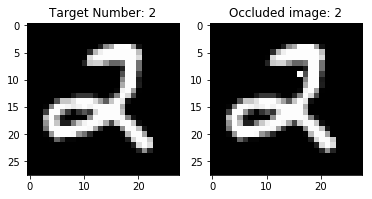

In [8]:
mask = torch.ones(1, 1, 28, 28)
mask[0, 0, 9, 16] = -1
oc_sample = sample * mask

fig, axes = plt.subplots(1, 2)
axes[0].imshow(unnormalize(sample.squeeze()), cmap="gray")
axes[0].set_title(f"Target Number: {sample_label.item()}")

axes[1].imshow(unnormalize(oc_sample.squeeze()), cmap="gray")
axes[1].set_title(f"Occluded image: {sample_label.item()}")

plt.show()

# Question:

why `ConvTranspose2d` can be seen as the gradient of `Conv2d` with respect to its input?

https://arxiv.org/abs/1603.07285

C matrix is 

https://en.wikipedia.org/wiki/Toeplitz_matrix

In [6]:
import sympy
from sympy import Symbol, Function, MatrixSymbol, Matrix
import numpy as np

In [7]:
def f(H, W, K, x, w):
    result = []
    for i in range(H-K+1):
        for j in range(W-K+1):
            result.append(np.sum(x[i:(K+i-1), j:(K+i-1)]*w))
    return result

In [8]:
x_input = MatrixSymbol("x^{(l)}", 5, 5)
x_output = MatrixSymbol("x^{(l+1)}", 3, 3)
w = MatrixSymbol("w", 3, 3)

In [9]:
def convolution(x, w, K, N):
    res = []
    for i in range(N-K+1):
        for j in range(N-K+1):
            a = sum(Matrix(x)[i:(K+i), j:(K+j)].multiply_elementwise(Matrix(w)))
            res.append(a)
    return Matrix(res).reshape(N-K+1, N-K+1)

In [10]:
o = convolution(x_input, w, K=3, N=5)
o

Matrix([
[w[0, 0]*x^{(l)}[0, 0] + w[0, 1]*x^{(l)}[0, 1] + w[0, 2]*x^{(l)}[0, 2] + w[1, 0]*x^{(l)}[1, 0] + w[1, 1]*x^{(l)}[1, 1] + w[1, 2]*x^{(l)}[1, 2] + w[2, 0]*x^{(l)}[2, 0] + w[2, 1]*x^{(l)}[2, 1] + w[2, 2]*x^{(l)}[2, 2], w[0, 0]*x^{(l)}[0, 1] + w[0, 1]*x^{(l)}[0, 2] + w[0, 2]*x^{(l)}[0, 3] + w[1, 0]*x^{(l)}[1, 1] + w[1, 1]*x^{(l)}[1, 2] + w[1, 2]*x^{(l)}[1, 3] + w[2, 0]*x^{(l)}[2, 1] + w[2, 1]*x^{(l)}[2, 2] + w[2, 2]*x^{(l)}[2, 3], w[0, 0]*x^{(l)}[0, 2] + w[0, 1]*x^{(l)}[0, 3] + w[0, 2]*x^{(l)}[0, 4] + w[1, 0]*x^{(l)}[1, 2] + w[1, 1]*x^{(l)}[1, 3] + w[1, 2]*x^{(l)}[1, 4] + w[2, 0]*x^{(l)}[2, 2] + w[2, 1]*x^{(l)}[2, 3] + w[2, 2]*x^{(l)}[2, 4]],
[w[0, 0]*x^{(l)}[1, 0] + w[0, 1]*x^{(l)}[1, 1] + w[0, 2]*x^{(l)}[1, 2] + w[1, 0]*x^{(l)}[2, 0] + w[1, 1]*x^{(l)}[2, 1] + w[1, 2]*x^{(l)}[2, 2] + w[2, 0]*x^{(l)}[3, 0] + w[2, 1]*x^{(l)}[3, 1] + w[2, 2]*x^{(l)}[3, 2], w[0, 0]*x^{(l)}[1, 1] + w[0, 1]*x^{(l)}[1, 2] + w[0, 2]*x^{(l)}[1, 3] + w[1, 0]*x^{(l)}[2, 1] + w[1, 1]*x^{(l)}[2, 2] + w[1, 2]*

In [14]:
C = o.reshape(1, 9).diff(Matrix(x_input).reshape(25, 1)).reshape(25, 9)
C

[[w[0, 0], 0, 0, 0, 0, 0, 0, 0, 0], [w[0, 1], w[0, 0], 0, 0, 0, 0, 0, 0, 0], [w[0, 2], w[0, 1], w[0, 0], 0, 0, 0, 0, 0, 0], [0, w[0, 2], w[0, 1], 0, 0, 0, 0, 0, 0], [0, 0, w[0, 2], 0, 0, 0, 0, 0, 0], [w[1, 0], 0, 0, w[0, 0], 0, 0, 0, 0, 0], [w[1, 1], w[1, 0], 0, w[0, 1], w[0, 0], 0, 0, 0, 0], [w[1, 2], w[1, 1], w[1, 0], w[0, 2], w[0, 1], w[0, 0], 0, 0, 0], [0, w[1, 2], w[1, 1], 0, w[0, 2], w[0, 1], 0, 0, 0], [0, 0, w[1, 2], 0, 0, w[0, 2], 0, 0, 0], [w[2, 0], 0, 0, w[1, 0], 0, 0, w[0, 0], 0, 0], [w[2, 1], w[2, 0], 0, w[1, 1], w[1, 0], 0, w[0, 1], w[0, 0], 0], [w[2, 2], w[2, 1], w[2, 0], w[1, 2], w[1, 1], w[1, 0], w[0, 2], w[0, 1], w[0, 0]], [0, w[2, 2], w[2, 1], 0, w[1, 2], w[1, 1], 0, w[0, 2], w[0, 1]], [0, 0, w[2, 2], 0, 0, w[1, 2], 0, 0, w[0, 2]], [0, 0, 0, w[2, 0], 0, 0, w[1, 0], 0, 0], [0, 0, 0, w[2, 1], w[2, 0], 0, w[1, 1], w[1, 0], 0], [0, 0, 0, w[2, 2], w[2, 1], w[2, 0], w[1, 2], w[1, 1], w[1, 0]], [0, 0, 0, 0, w[2, 2], w[2, 1], 0, w[1, 2], w[1, 1]], [0, 0, 0, 0, 0, w[2, 2], 0, 

In [51]:
# forward 
(Matrix(x_input).reshape(1, 25) @ C).reshape(3, 3)

Matrix([
[w[0, 0]*x^{(l)}[0, 0] + w[0, 1]*x^{(l)}[0, 1] + w[0, 2]*x^{(l)}[0, 2] + w[1, 0]*x^{(l)}[1, 0] + w[1, 1]*x^{(l)}[1, 1] + w[1, 2]*x^{(l)}[1, 2] + w[2, 0]*x^{(l)}[2, 0] + w[2, 1]*x^{(l)}[2, 1] + w[2, 2]*x^{(l)}[2, 2], w[0, 0]*x^{(l)}[0, 1] + w[0, 1]*x^{(l)}[0, 2] + w[0, 2]*x^{(l)}[0, 3] + w[1, 0]*x^{(l)}[1, 1] + w[1, 1]*x^{(l)}[1, 2] + w[1, 2]*x^{(l)}[1, 3] + w[2, 0]*x^{(l)}[2, 1] + w[2, 1]*x^{(l)}[2, 2] + w[2, 2]*x^{(l)}[2, 3], w[0, 0]*x^{(l)}[0, 2] + w[0, 1]*x^{(l)}[0, 3] + w[0, 2]*x^{(l)}[0, 4] + w[1, 0]*x^{(l)}[1, 2] + w[1, 1]*x^{(l)}[1, 3] + w[1, 2]*x^{(l)}[1, 4] + w[2, 0]*x^{(l)}[2, 2] + w[2, 1]*x^{(l)}[2, 3] + w[2, 2]*x^{(l)}[2, 4]],
[w[0, 0]*x^{(l)}[1, 0] + w[0, 1]*x^{(l)}[1, 1] + w[0, 2]*x^{(l)}[1, 2] + w[1, 0]*x^{(l)}[2, 0] + w[1, 1]*x^{(l)}[2, 1] + w[1, 2]*x^{(l)}[2, 2] + w[2, 0]*x^{(l)}[3, 0] + w[2, 1]*x^{(l)}[3, 1] + w[2, 2]*x^{(l)}[3, 2], w[0, 0]*x^{(l)}[1, 1] + w[0, 1]*x^{(l)}[1, 2] + w[0, 2]*x^{(l)}[1, 3] + w[1, 0]*x^{(l)}[2, 1] + w[1, 1]*x^{(l)}[2, 2] + w[1, 2]*

In [53]:
# backward
(Matrix(x_output).reshape(1, 9) @ C.transpose()).reshape(5, 5)

Matrix([
[                                                    w[0, 0]*x^{(l+1)}[0, 0],                                                                                                         w[0, 0]*x^{(l+1)}[0, 1] + w[0, 1]*x^{(l+1)}[0, 0],                                                                                                                                                             w[0, 0]*x^{(l+1)}[0, 2] + w[0, 1]*x^{(l+1)}[0, 1] + w[0, 2]*x^{(l+1)}[0, 0],                                                                                                         w[0, 1]*x^{(l+1)}[0, 2] + w[0, 2]*x^{(l+1)}[0, 1],                                                     w[0, 2]*x^{(l+1)}[0, 2]],
[                          w[0, 0]*x^{(l+1)}[1, 0] + w[1, 0]*x^{(l+1)}[0, 0],                                                     w[0, 0]*x^{(l+1)}[1, 1] + w[0, 1]*x^{(l+1)}[1, 0] + w[1, 0]*x^{(l+1)}[0, 1] + w[1, 1]*x^{(l+1)}[0, 0],                                                            